## Base Network

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
len(words)

32033

In [8]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) 
b2 = torch.randn(vocab_size,                      generator=g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [11]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
  

      0/ 200000: 27.8817
  10000/ 200000: 2.8050
  20000/ 200000: 2.5518
  30000/ 200000: 2.8035
  40000/ 200000: 2.0476
  50000/ 200000: 2.7033
  60000/ 200000: 2.3179
  70000/ 200000: 2.0966
  80000/ 200000: 2.3344
  90000/ 200000: 2.2155
 100000/ 200000: 2.0712
 110000/ 200000: 2.4086
 120000/ 200000: 1.8661
 130000/ 200000: 2.3103
 140000/ 200000: 2.2350
 150000/ 200000: 2.1742
 160000/ 200000: 2.1190
 170000/ 200000: 1.7579
 180000/ 200000: 2.0183
 190000/ 200000: 1.8186


In [12]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1256532669067383
val 2.1684703826904297


In [13]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

carlah.
amille.
khy.
mili.
taty.
skanden.
jazonen.
den.
art.
kaqui.
nextara.
chaiir.
kaleigh.
ham.
jorn.
quint.
salin.
alianni.
wazthoniearyn.
kai.


## Improving the Loss

### Method 1

**Ideally we want the loss to be 3.29 at initialization, which is with uniform probs.**

1. We want the logits to be uniform at initialization (meaning 0), so we want to make b2 = 0 since we don't want to add a random bias.
2. We want to scale down W2 as well, to make the probs as low as possible without completely zeroing them.

By initializing the weights to be uniform, we're getting rid of the first few cycles, which are spent just squashing down the loss, and instead, focus all of our cycles on the hard part of reducing the loss. This is because by adding a random bias, the logits can take on extremely low and high values, making the first few cycles of training useful for just bringing down the loss significantly from a really high number to a number close to our desired loss.

In [14]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g) 
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0 

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [15]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8644
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


In [16]:
@torch.no_grad() # this decorator disables gradient tracking, which we don't need here since we're not training

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0695888996124268
val 2.131074905395508


### Method 2

**Another thing we want to address is the hidden layer activations.**

In [17]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) 
b1 = torch.randn(n_hidden,                        generator=g)
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [18]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break

      0/ 200000: 3.3221


(array([2069.,  144.,  106.,   82.,   59.,   56.,   43.,   31.,   43.,
          26.,   16.,   38.,   16.,   32.,   24.,   14.,   28.,   27.,
          26.,   19.,   24.,   26.,   30.,   14.,   19.,   19.,   22.,
          26.,   18.,   12.,   10.,   33.,   27.,   32.,   17.,   24.,
          30.,   22.,   26.,   29.,   26.,   40.,   29.,   41.,   49.,
          64.,   62.,  100.,  188., 2442.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

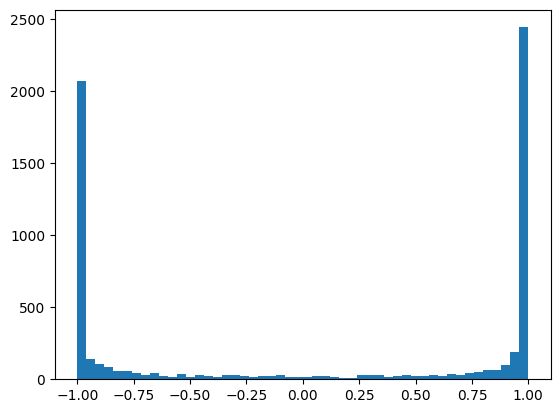

In [19]:
plt.hist(h.view(-1).tolist(), 50)

The graph above shows us the amount of neurons that are either 1 or -1 (basically the amount of dead gradients) by being marked in white.

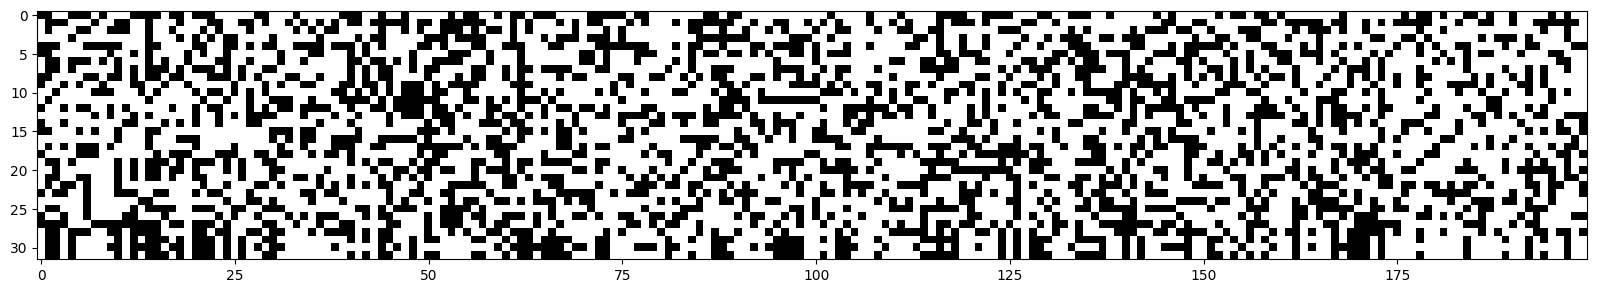

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap ='gray', interpolation='nearest')

As shown above, most values are either -1 or 1, since the pre-activations have a high range before the squashing. When this happens, we call the tanh "active".

This is bad because when we backpropagate through a tanh neuron, the calculation for the gradient is (1 - t^2) * out.grad. When t = 1 or -1, t^2 becomes 1, and the gradient ends up being 0, meaning the weights of the layer don't update. 

Essentially, since most of the tanh neurons here are either 1 or -1, the gradients are actually getting destroyed as they flow through. 

In the case that a neuron never updates in all examples of a batch, we call it a dead neuron. This would happen if all of the pre-activations for a certain neuron were either really high or low, which would result in the tanh outputting -1 or 1. This is observable in the graph above if an entire column is white - this means that the neuron has a zero gradient for all 32 examples.

To fix this, we want to squash the values in the first bias layer (b1) by multiplying by a small amount, so that they become more uniformly distributed.

We can do this as such:

In [21]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # we can squash the weights as well
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [22]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


**Now we can see that the histogram is a lot more uniformly distributed, and as a result, there is much less white in the neuron map.**

(array([ 959.,  218.,  145.,  120.,  103.,  102.,   72.,   85.,   75.,
          70.,   69.,   74.,   69.,   68.,   76.,   65.,   49.,   77.,
          49.,  105.,   90.,   91.,  107.,   87.,   92.,  124.,  133.,
         101.,  101.,  120.,   71.,   86.,   60.,   73.,   44.,   73.,
          55.,   59.,   37.,   63.,   64.,   59.,   81.,   76.,   78.,
         133.,  130.,  143.,  261., 1058.]),
 array([-1.00000000e+00, -9.60000001e-01, -9.20000002e-01, -8.80000004e-01,
        -8.40000005e-01, -8.00000006e-01, -7.60000007e-01, -7.20000008e-01,
        -6.80000010e-01, -6.40000011e-01, -6.00000012e-01, -5.60000013e-01,
        -5.20000014e-01, -4.80000015e-01, -4.40000017e-01, -4.00000018e-01,
        -3.60000019e-01, -3.20000020e-01, -2.80000021e-01, -2.40000023e-01,
        -2.00000024e-01, -1.60000025e-01, -1.20000026e-01, -8.00000274e-02,
        -4.00000286e-02, -2.98023224e-08,  3.99999690e-02,  7.99999678e-02,
         1.19999967e-01,  1.59999965e-01,  1.99999964e-01,  2.399999

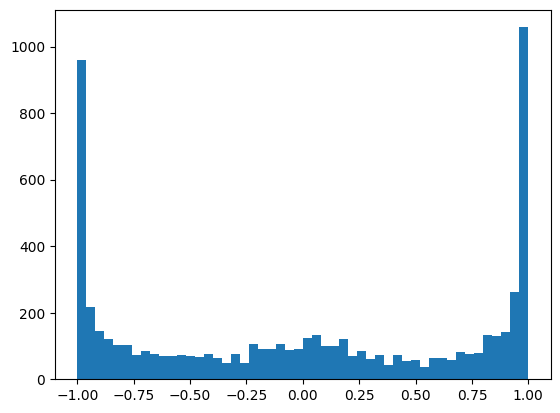

In [23]:
plt.hist(h.view(-1).tolist(), 50)

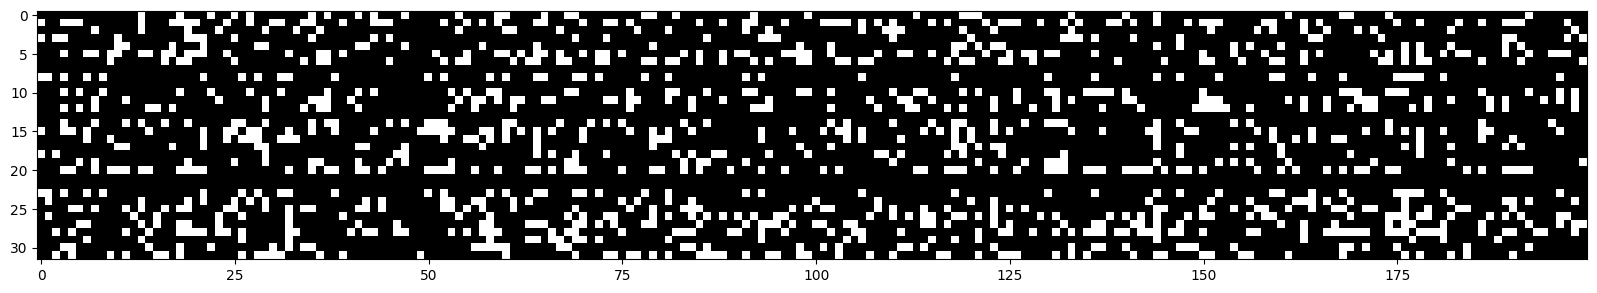

In [24]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap ='gray', interpolation='nearest')

In [25]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0355966091156006
val 2.1026785373687744


### loss log:

**original:**

train: 2.12, 
val: 2.16

**fix softmax being confidently wrong:**

train: 2.07, 
val: 2.13

**fix tanh layer too saturated at init:**

train: 2.036, 
val: 2.10

The reason the loss improved with the two adjustments we made was primarily because we spent more time doing productive training.

### Note:

Because the network is very shallow, it was forgiving with the bad initialization and still ended up learning its way to a low loss. However, if we were to train larger networks, a bad initialization would prevent the network from ever decreasing its loss to a reasonable amount. In general, the deeper your network is, the less forgiving it is for the errors we made while training this network.

**The next question is figuring out how to determine the values we multiply the weights and biases by; 0.01 and 0.2 are very arbitrary, but nobody determines these manually in practice - there is a method to do this.**

tensor(0.0064) tensor(1.0019)
tensor(-0.0157) tensor(3.1341)


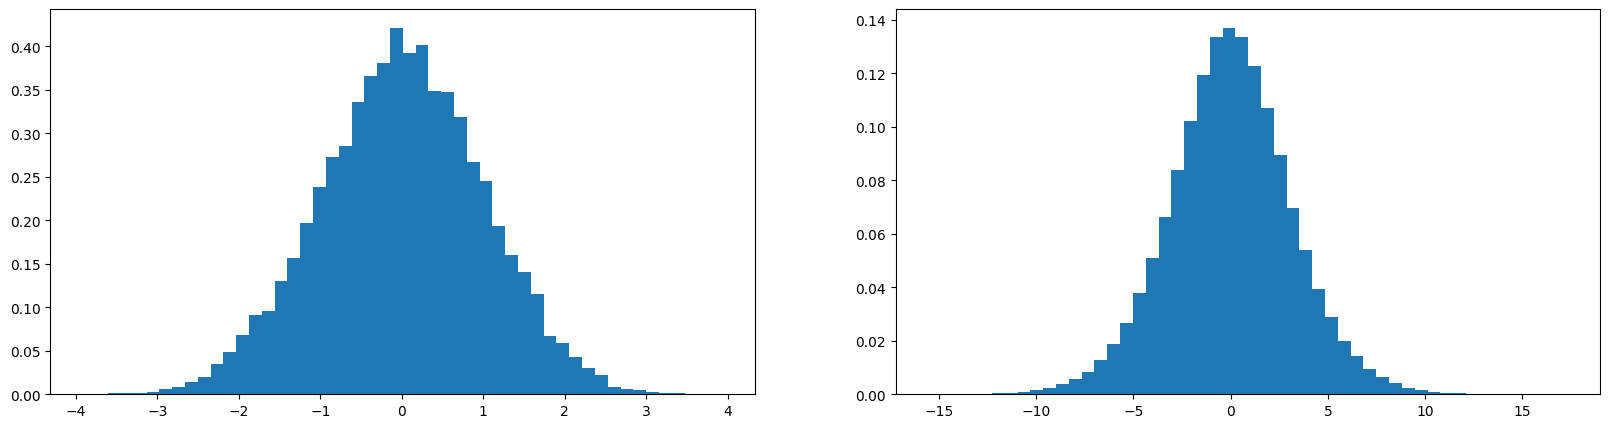

In [26]:
# sample code for an input layer and weights layer to get the pre-activations in a network

x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In the graphs above, the mean stays the same, but the std increases from 1 to 3.17 due to the multiplication. In an MLP, we don't want this happening and want to to keep the std the same throughout the network because the logits would become really large otherwise, and we'd have to spend more time squashing the network down. 

We can achieve this by dividing each layer that's being multiplied by the "fan-in", which is essentially the square root of the number of inputs. 

**In the case above, this would mean dividing by 10^0.5.**

tensor(0.0162) tensor(1.0038)
tensor(-0.0026) tensor(0.9974)


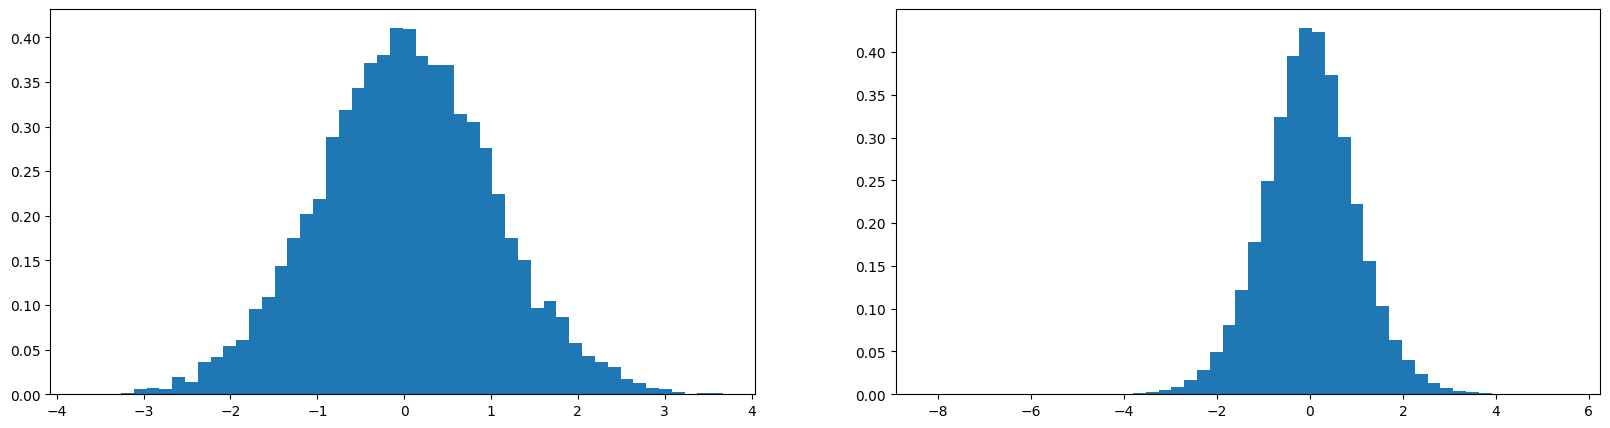

In [27]:
# sample code for an input layer and weights layer initialized with a gaussian distribution to get the pre-activations in a network

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

There's been a lot of research done to determine how we can make the pre-activations not blow up to infinity but also not squash down to zero. There's one paper in particular, by Kaiming et. al, that discusses multiplying the activations by the square root of 2/fan-in of the layer. They were covering ReLU in this paper, which is why they do 2/fan-in, but for tanh we can do 1/fan-in, since we didn't have a non-linearity. 

This initialization has been implemented in PyTorch, as the kaiming_normal_ and it is the most popular way of initializing a neural net. The formula is std = gain/(fan_mode)**0.5. The gain is calculated based on the non-linearity you're using and this information can be found in the PyTorch docs. For tanh, the gain is 5/3.

In [28]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [29]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3179
  10000/ 200000: 2.1910
  20000/ 200000: 2.3270
  30000/ 200000: 2.5396
  40000/ 200000: 1.9468
  50000/ 200000: 2.3331
  60000/ 200000: 2.3852
  70000/ 200000: 2.1173
  80000/ 200000: 2.3159
  90000/ 200000: 2.2010
 100000/ 200000: 1.8591
 110000/ 200000: 2.0881
 120000/ 200000: 1.9389
 130000/ 200000: 2.3913
 140000/ 200000: 2.0949
 150000/ 200000: 2.1458
 160000/ 200000: 1.7824
 170000/ 200000: 1.7249
 180000/ 200000: 1.9752
 190000/ 200000: 1.8614


In [30]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0376641750335693
val 2.106989622116089


The loss ends up being almost the same, but now we have an initliazation method that we can carry forward to training larger networks and don't have to worry about manually finding the multiplying factor.

## Batch Normalization

Batch normalization is really useful when training large networks. When we're initializing a network, we want the hidden pre-activations (hpreact) to be of a gaussian distribution. The insight of batch normalization is that if the pre-activations are not gaussian at initialization, you can just make them gaussian. This is possible because the the mathematical operation to make them gaussian is easily differentiable.

In [31]:
hpreact.shape

torch.Size([32, 200])

In [32]:
hpreact.mean(0, keepdim=True).shape # we're taking the mean of all the elements in a batch

torch.Size([1, 200])

In [33]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [34]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# we are adding the two parameters above becausae we want the hpreact to only be gaussian at initialization and we don't want it to be be 
# forced to stay gaussian - we want to give the network freedom to adjust the parameters as it wishes. 
# Therefore, adding a gain and a bias would make it easily differentiable while still giving the network the freedom it needs.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12297


In [35]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    #print(loss.item())

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad


    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


In [40]:
# by doing this, we can calibrate the batch norm at the end of the training, so that we don't have to dynamically calculate it during testing

with torch.no_grad():
    
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

As seen below, because bnmean and bnmean_running are very similar, we can actually get rid of the explicit calculation at the end of the training above and just use the runnning values. The bnmean_running and bn__std running also aren't trained with the neural network, they're trained the equation that updates the running values.

In [41]:
bnmean

tensor([[-2.3355,  0.6775, -0.9132,  1.0163,  1.0866,  1.0938,  1.7437, -2.1208,
          0.5730,  1.4455, -1.6344, -2.7372, -0.4752, -0.1412, -0.0745, -1.1722,
          0.6851, -2.6219, -0.1065,  1.6326, -0.7706, -0.3063,  0.0479,  0.6115,
          1.1173,  0.2427,  2.0500,  0.5831,  0.8527,  1.7680, -0.3625, -0.8356,
         -0.0854, -0.5177, -0.3806, -1.0698, -0.0786,  0.3487, -0.5808,  0.9875,
         -0.4427, -1.3082, -0.2871, -0.2332,  0.6850,  0.6850,  2.0856, -0.7608,
          2.3866,  1.8734,  0.8260,  0.2803,  1.8897,  0.4709,  0.6739, -1.8940,
         -0.0401,  0.4338,  1.3760, -0.8910, -0.4524,  1.1754,  0.5613,  0.6051,
          1.5858,  1.2261, -1.0111,  2.1495, -0.6392,  0.0938, -0.2864, -0.4856,
          0.9632, -1.0461, -2.9990,  0.6391,  1.4327, -0.1590,  0.0940,  0.5253,
          0.2508,  1.2521,  2.0388,  0.6608,  0.0691, -0.0813, -1.6723,  0.2933,
          2.2423, -0.0210, -0.6666,  1.4253, -0.8412, -1.2248, -1.0128,  0.2230,
          0.2113, -0.3226,  

In [42]:
bnmean_running

tensor([[-2.3539,  0.6872, -0.9000,  1.0159,  1.0894,  1.0862,  1.7389, -2.1356,
          0.5608,  1.4246, -1.6445, -2.7426, -0.4861, -0.1510, -0.0687, -1.1549,
          0.6891, -2.6399, -0.1283,  1.6240, -0.7732, -0.2865,  0.0467,  0.6119,
          1.1172,  0.2433,  2.0542,  0.5778,  0.8515,  1.7729, -0.3741, -0.8385,
         -0.0831, -0.5198, -0.3816, -1.0698, -0.0781,  0.3370, -0.5768,  0.9935,
         -0.4507, -1.3313, -0.2895, -0.2299,  0.6876,  0.6936,  2.0835, -0.7759,
          2.3804,  1.8614,  0.8118,  0.2735,  1.8802,  0.4705,  0.6656, -1.8962,
         -0.0420,  0.4356,  1.3924, -0.8906, -0.4676,  1.1688,  0.5539,  0.6001,
          1.5853,  1.2103, -1.0171,  2.1422, -0.6330,  0.1071, -0.2925, -0.4831,
          0.9506, -1.0144, -2.9925,  0.6268,  1.4404, -0.1574,  0.0955,  0.5159,
          0.2487,  1.2400,  2.0104,  0.6695,  0.0768, -0.0851, -1.6767,  0.2963,
          2.2374, -0.0100, -0.6669,  1.4356, -0.8431, -1.2317, -1.0220,  0.2201,
          0.1929, -0.3261,  

In [43]:
@torch.no_grad() # this decorator disables gradient tracking

def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1 # the biases are useless here with batch norm implemented, since we take the mean
    # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0666232109069824
val 2.1051769256591797


The validation loss will essentially be the same as before since this is a very small network. However, if we implement this on larger network, the improved loss will be very clear.

Also, rather than tuning every layer of weights to be roughly gaussian, it's easier to sprinkle in a few batch norm layers throughout the network. 

The conventional way to do this is to take a linear or convolutional layer (any layer that consists of wx + b) and append a batch norm layer right after it, as done above with hpreact.

Something interesting about training in batches is that the parameters will be slightly different each time they're trained because they're adjusted relative to the other examples in their batch. This introduces a jitter to the parameters, where they slightly jitter throughout training, which pads out the inputs and introduces entropy, making it hard to overfit the model to the examples. It essentially acts as a regularizer. This is another reason why it's hard to remove the use of batch normalization.

**Explanation of PyTorch:**

- The linear layer takes in the input size, output size, and if there should be a bias. When initialzing the weights, it uses a uniform distribution instead of a gaussian distribution, where they draw from -root(k) to root(k), where k = 1/input_size.

## PyTorchifying the Code

In [90]:
class Linear: # modeled after torch.nn.Linear (in_features, out_features, bias=True, device=None, dtype=None) - we're omitting the last 2 paraneters
    # default device is CPU, dtype is float32
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 # second part is the kaiming initialization discussed earlier
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class BatchNorm1d: # modeled after torch.nn.BatchNorm1d(num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True, device=None, dtype=None)
    def __init__(self, dim, eps=1e-5, momentum=0.1): # 

        # saving the values
        self.eps = eps
        self.momentum = momentum
        self.training = True # we use this because during training, we use the batch mean and variance, whereas during inference we use the running values
        
        # parameters (trained with backprop)
        
        # affine=True in torch.nn.BatchNorm1d means we're using a gain and bias or gamma and beta, which we are below:
        self.gamma = torch.ones(dim) # gain 
        self.beta = torch.zeros(dim) # bias
        
        # track_running_stats=True means we're keeping track of running mean and variance
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim) # running variance (std^2); we're using variance bc that's what used in the paper

    def __call__(self, x):
        # calculate the fwd pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance (this is the formula used in PyTorch)
        self.out = self.gamma * xhat + self.beta # self.out is used here to keep track of the stats to graph them later, but it's not present in PT
        # update the buffers
        if self.training:
            with torch.no_grad(): # tells PT to not keep track of the gradients, which makes it more efficient
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean 
                # this method of training used to update the buffer values is called exponential moving avg
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return[]

n_embd = 10 # dimentionality of the character embedding vectors
n_hidden = 100 # number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C  = torch.randn((vocab_size, n_embd))
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
with torch.no_grad():

    # this section is the first change we made, where we squashed the weights of the last layer
    # last layer: make less confident
    # layers[-1].weight += 0.1 # since the last layer is a batchnorm layer, we want to change the gamma, which is essentially the weight because it's multiplied by the output of the previous layer
    layers[-1].gamma += 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1.0 # without batchnorm it would have to be 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # of parameters in total
for p in parameters:
    p.requires_grad = True

47024


In [91]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
      break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 4.1491


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 2.81%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.41%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 2.41%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.84%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.47%


Text(0.5, 1.0, 'activation distribution')

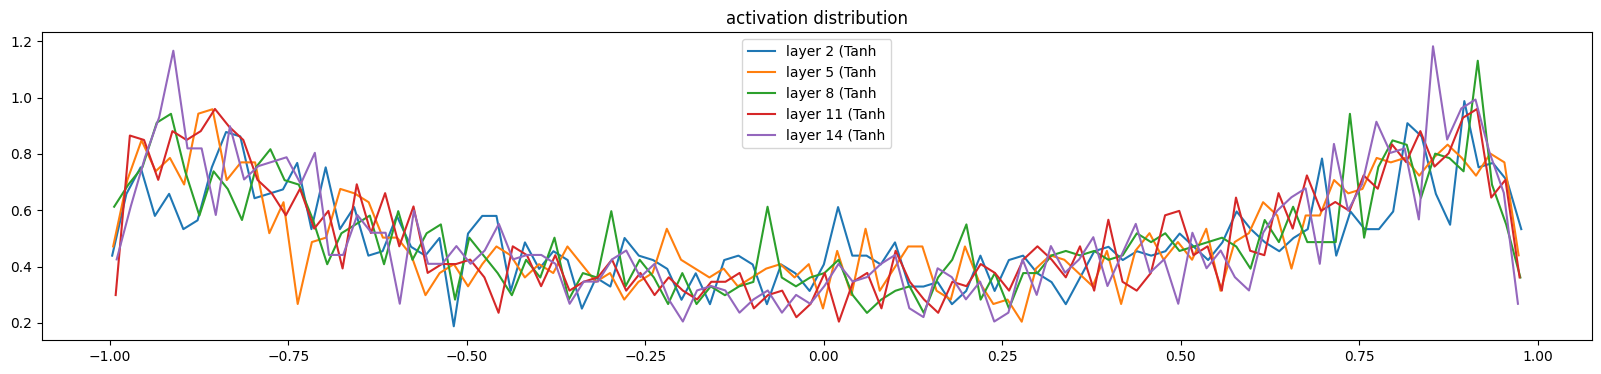

In [92]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

Multiplying the weights layer by 5/3 keeps the saturation of the activations low, which is good because the more saturated they are (more values on the tails), the more the gradients get erased during backprop. If we use a gain of 1, it would be too low, and the activations would slowly get squashed to zero with more layers added, since tanh is a squashing function. WE need a gain to combat the squashing of the tanh. However, if we use a gain too high such as 2 or 3, the values become too saturated and essentially become useless. 

layer 2 (      Tanh): mean +0.000000, std 2.608525e-03
layer 5 (      Tanh): mean -0.000000, std 2.373106e-03
layer 8 (      Tanh): mean -0.000000, std 2.247639e-03
layer 11 (      Tanh): mean -0.000000, std 2.174679e-03
layer 14 (      Tanh): mean +0.000000, std 2.465564e-03


Text(0.5, 1.0, 'gradient distribution')

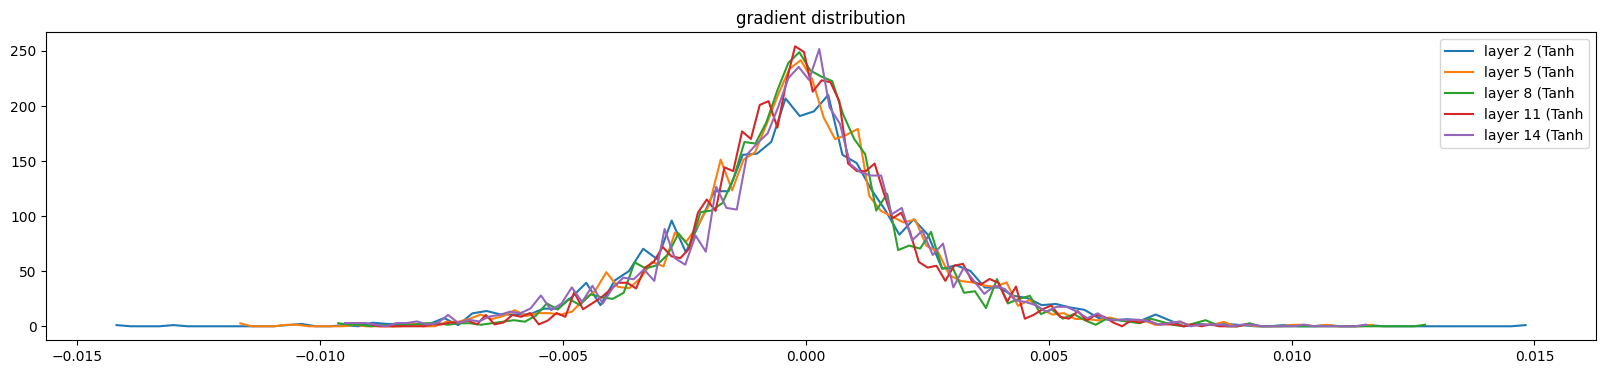

In [93]:

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

If the gain is too small, the gradients would explode and if it's too large, they'd eventually shrink.

**Without tanh layers, the activations and gradients would either diffuse or explode.**

weight   (27, 10) | mean -0.000000 | std 7.369603e-03 | grad:data ratio 6.920062e-03
weight  (30, 100) | mean -0.000142 | std 6.638982e-03 | grad:data ratio 2.148403e-02
weight (100, 100) | mean +0.000030 | std 5.331064e-03 | grad:data ratio 3.155507e-02
weight (100, 100) | mean +0.000055 | std 4.787038e-03 | grad:data ratio 2.848588e-02
weight (100, 100) | mean -0.000041 | std 4.451484e-03 | grad:data ratio 2.647280e-02
weight (100, 100) | mean +0.000000 | std 4.495505e-03 | grad:data ratio 2.657133e-02
weight  (100, 27) | mean +0.000003 | std 9.764767e-03 | grad:data ratio 5.793945e-02


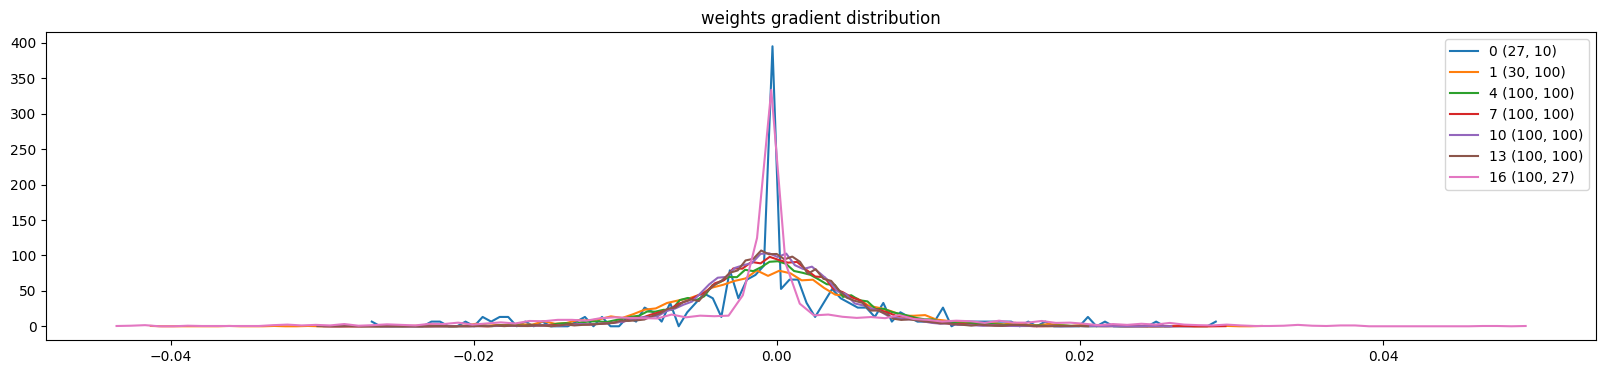

In [94]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

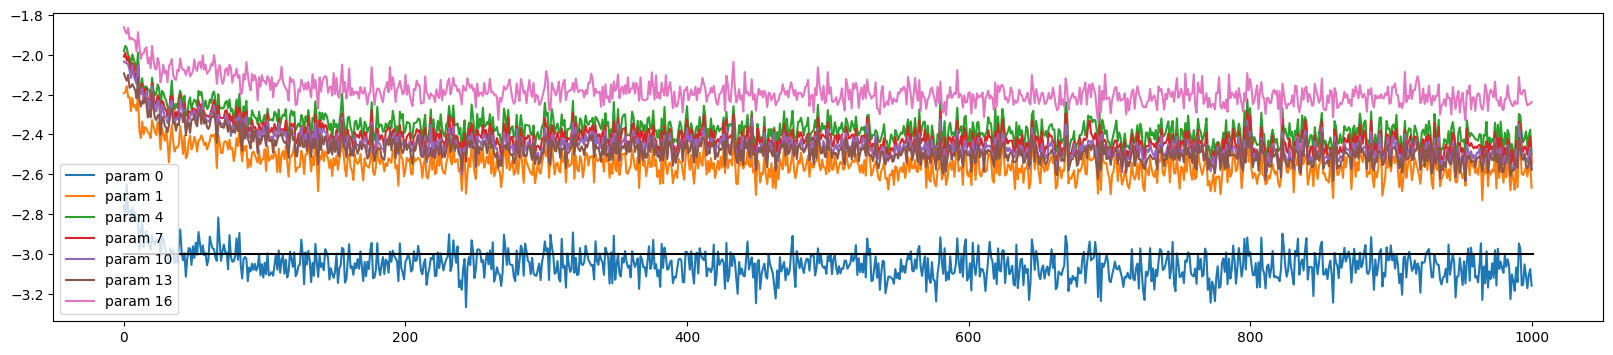

In [95]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

The plot above shows the update to data ratio (how much the weights are getting tweaked by, relative to their values). Ideally, it should be around 1e-3 (-3.0 on the graph), meaning the weights are being updated by a thousandth of their values. The last layer (in pink) is really high because we multiply it by 0.1 during initialization, so the update is much larger relative to the values, but if we run a few more iterations, the updates will become smaller as the layer learns.

This graph is also great to show if your learning rate is too low or too high, based on where the graphs are relative to the -3.0 line.

**Note:**

Adding the batchnorm layer makes it so that we don't have to worry too much about having the exact gain and overall gives us more leeway. In fact, we don't even have to initialize with the fan-in to have a well-behaved network.